---
layout: post  
---

The objective of this post is to evaluate the relationship between sequencing error rates, depth of coverage, and kmer length.

When resequencing a genome with high redundancy (depth of coverage), the number of _unique_ erroneous kmers observed will dominate the number of _unique_ "true" kmers observed.

The reasoning for this is as follows:
For every $$k$$-length subsequence in a genome that we can observe, there are $$(k^4)-1$$ possible errors that can be made.
Given enough observations, we will eventually observe all of those possible errors.

While all techniques or assembling a genome from observed sequences have some method for separating "true" kmers from erroneous ones, we'd like to resolve errors using the smallest $$k$$ length possible.
By minimizing $$k$$, we minimize the number of possible erroneous kmers that we have to deal with, saving time and computational resources.

Here we will simulate a few genetic sequences and investigate the scaling patterns of erroneous vs "true" kmers at reasonable depth-of-coverage and error rates.

In [1]:
import Pkg
pkgs = [
    "BioSequences",
    "StatsPlots",
    "Random",
    "StatsBase",
    "PlotlyJS",
    "Primes",
    "BioSymbols",
    "DataFrames",
    "ProgressMeter",
    "Colors",
    "Measures"
]

Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end

StatsPlots.plotlyjs()

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-8084419248346317002\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4061454251887445757\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-8084419248346317002\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Plots.PlotlyJSBackend()

In [2]:
function observe(sequence; error_rate = error_rate, alphabet = BioSymbols.ACGT)
    new_seq = Vector{eltype(sequence)}()
    for character in sequence
        if rand() > error_rate
            # match
            push!(new_seq, character)
        else
            error_type = rand(1:3)
            if error_type == 1
                # mismatch
                push!(new_seq, rand(setdiff(alphabet, character)))
            elseif error_type == 2
                # insertion
                push!(new_seq, rand(alphabet))
                push!(new_seq, character)
            else
                # deletion
                continue
            end
        end
    end
    return_seq = BioSequences.LongDNASeq(new_seq)
    if rand(Bool)
        return_seq = BioSequences.reverse_complement!(return_seq)
    end
    return return_seq
end

observe (generic function with 1 method)

Here we will run the simulations

In [3]:
function assess_kmers(K::Val{k}, coverage, sequence, error_rate) where k
    KMER_TYPE = BioSequences.DNAMer{k}
    kmers = Set{KMER_TYPE}()
    for i in 1:coverage
        observation = observe(sequence, error_rate = error_rate)
        for kmer_set in BioSequences.each(KMER_TYPE, observation)
            push!(kmers, BioSequences.canonical(kmer_set.fw))
        end
    end
    unique_kmers = length(kmers)
    result = (
            k = k,
            error_rate = error_rate,
            sequence_length = length(sequence),
            coverage = coverage,
            unique_kmers = unique_kmers
            )
    return result
end

assess_kmers (generic function with 1 method)

In [4]:
results = 
DataFrames.DataFrame(
    k = [],
    error_rate = [],
    sequence_length = [],
    coverage = [],
    unique_kmers = [])

sequence_lengths = [10^i for i in 2:5]
for (iteration, sequence_length) in enumerate(sequence_lengths)
    # one sequence per size
    sequence = BioSequences.randdnaseq(Random.seed!(iteration), sequence_length)
    ProgressMeter.@showprogress for error_rate in [0.0, 0.001, 0.01, 0.1]
        for coverage in [10^i for i in 1:3]
            for k in Primes.primes(3, 31)
                # using Val makes this type stable and SO MUCH FASTER
                result = assess_kmers(Val(k), coverage, sequence, error_rate)
                push!(results, result)
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:25
Progress: 100%|█████████████████████████████████████████| Time: 0:05:13


In [5]:
error_to_linestyles = Dict(
    a => b for (a, b) in zip(sort(unique(results[!, "error_rate"])), [:solid, :dash, :dot, :dashdot])
)

Dict{Float64,Symbol} with 4 entries:
  0.0   => :solid
  0.01  => :dot
  0.1   => :dashdot
  0.001 => :dash

In [6]:
coverage_to_markershape = Dict(
    a => b for (a, b) in zip(sort(unique(results[!, "coverage"])), [:circle, :rect, :cross])
)

Dict{Int64,Symbol} with 3 entries:
  100  => :rect
  10   => :circle
  1000 => :cross

And here we will plot the results by sequence length

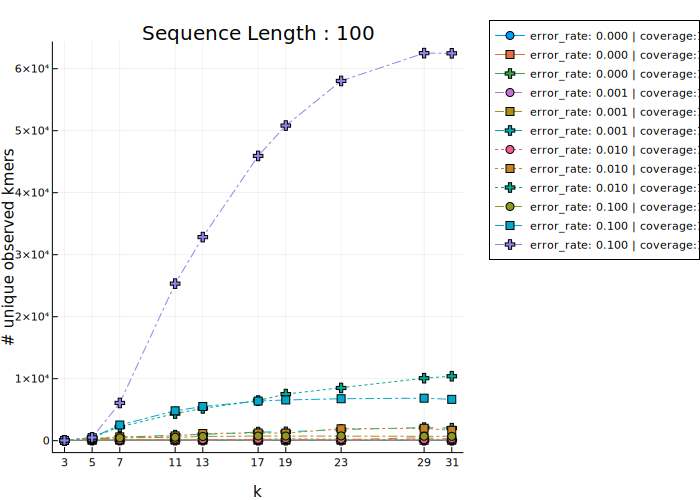

![](/assets/images/2020-12-19-observed-kmers-vs-error-rate-100.svg)

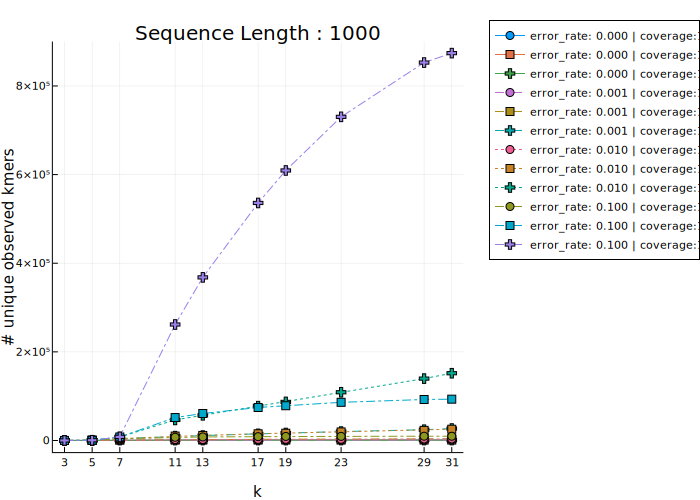

![](/assets/images/2020-12-19-observed-kmers-vs-error-rate-1000.svg)

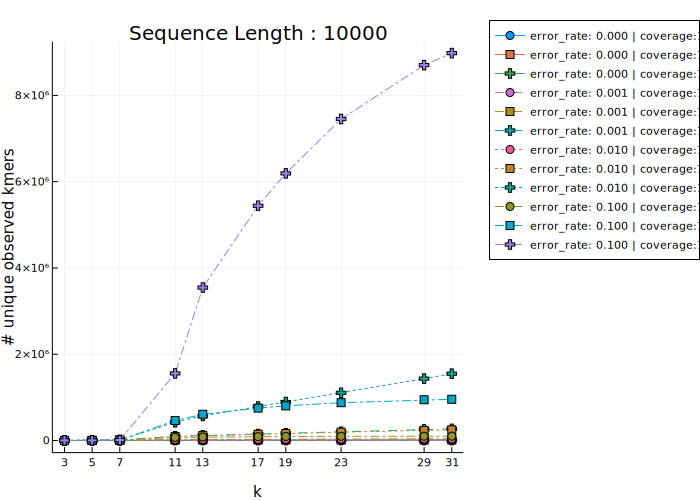

![](/assets/images/2020-12-19-observed-kmers-vs-error-rate-10000.svg)

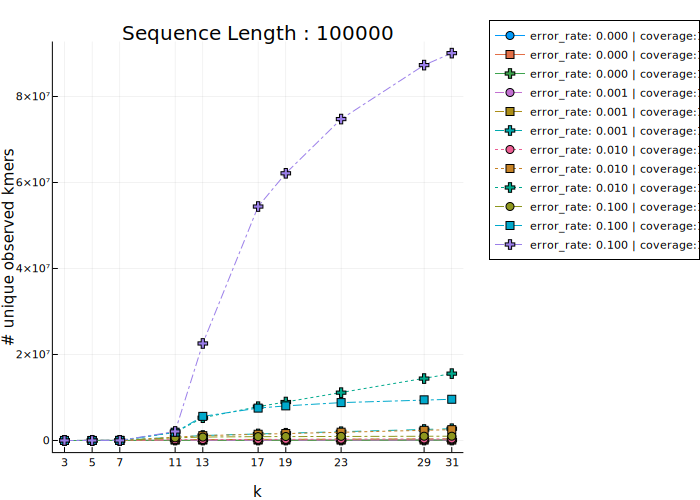

![](/assets/images/2020-12-19-observed-kmers-vs-error-rate-100000.svg)

In [7]:
for sequence_length in sort(unique(results[!, "sequence_length"]))
    p = StatsPlots.plot(
        title = "Sequence Length : $(sequence_length)",
        xlabel = "k",
        ylabel = "# unique observed kmers",
        legend = :outertopright,
        size = (700, 500),
        leftmargin = 5(Measures.mm)
    )

    for error_rate in sort(unique(results[!, "error_rate"]))
        for coverage in sort(unique(results[!, "coverage"]))
            indices = (
                (results[!, "sequence_length"] .== sequence_length) .&
                (results[!, "error_rate"] .== error_rate) .&
                (results[!, "coverage"] .== coverage))
            xs = results[indices, "k"]
            ys = results[indices, "unique_kmers"]

            p = StatsPlots.plot!(p,
                xs,
                ys,
                xticks = (xs, string.(xs)),
                linestyle = error_to_linestyles[error_rate],
                markershape = coverage_to_markershape[coverage],
                label = "error_rate: $(rpad(error_rate, 5, '0')) | coverage:$(coverage)"
            )
        end
    end
    
    filename = "/assets/images/2020-12-19-observed-kmers-vs-error-rate-$(sequence_length).svg"
    full_file_path = dirname(pwd()) * filename
    StatsPlots.savefig(p, full_file_path)

    # displays in notebook
    display("image/svg+xml", read(full_file_path, String))
    
    # displays on website
    display("text/markdown", "![]($filename)")
end

We are able to see some interesting scaling differences very quickly!

Note that the lowest trend line on these plot indicates the number "true" kmers.
Any value above the lowest is equal to $$\text{"true"} + \text{erroneous}$$

The top two lines in each of these plots have "cross" marker shapes, indicating 1000x coverage.

This indicates that a 10x increase in coverage contributed more to overall noise than a 10x increase in error rate.

These results also indicate that the divergence zone for when the erroneous noise signal out-paces the "true" signal occurs around
$$7 >= k <= 11$$

We're not able to see much detail in the results with lower error rates and depth of coverage because of how much the `error_rate: 0.100 | coverage: 1000` results dominate the rest.
We'll also plot these results on a $log2(y)$ transformed axis.

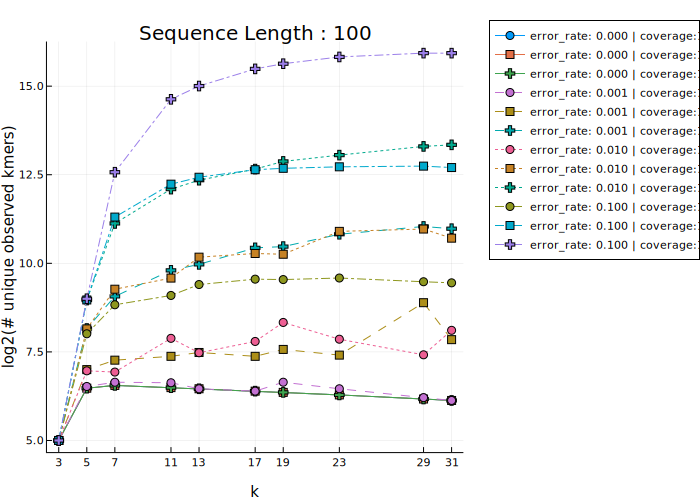

![](/assets/images/2020-12-19-observed-kmers-vs-error-rate-100.log.svg)

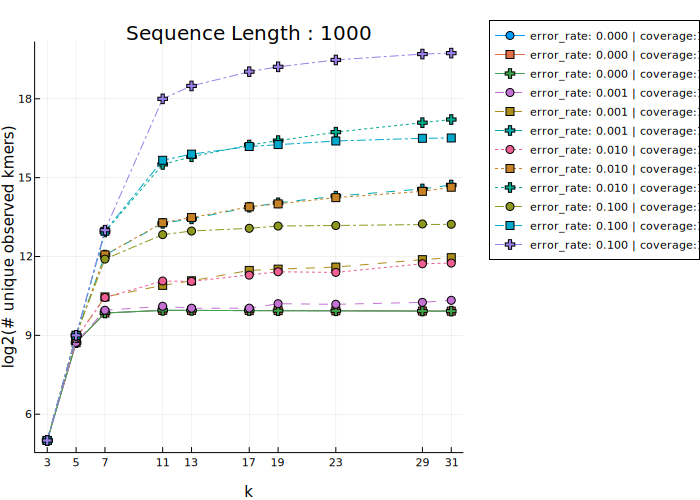

![](/assets/images/2020-12-19-observed-kmers-vs-error-rate-1000.log.svg)

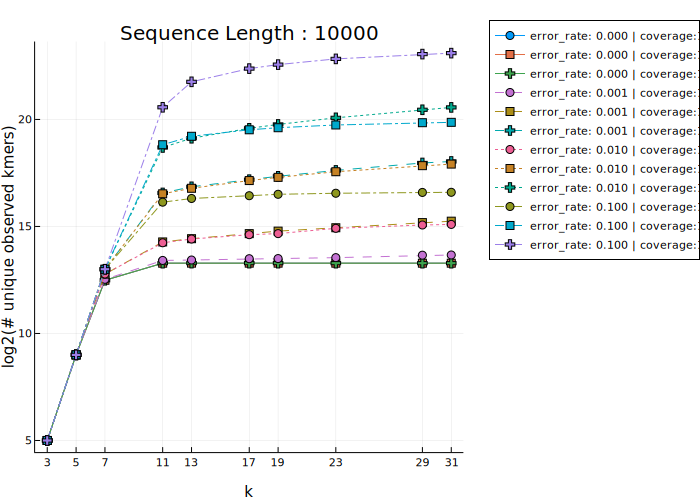

![](/assets/images/2020-12-19-observed-kmers-vs-error-rate-10000.log.svg)

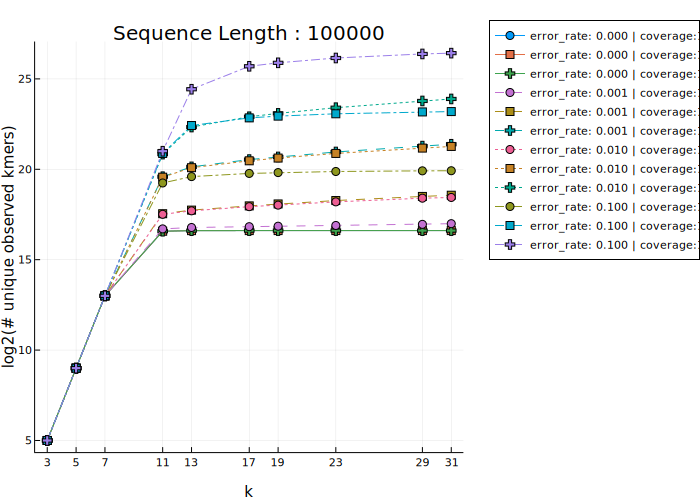

![](/assets/images/2020-12-19-observed-kmers-vs-error-rate-100000.log.svg)

In [8]:
for sequence_length in sort(unique(results[!, "sequence_length"]))
    p = StatsPlots.plot(
        title = "Sequence Length : $(sequence_length)",
        xlabel = "k",
        ylabel = "log2(# unique observed kmers)",
        legend = :outertopright,
        size = (700, 500),
        leftmargin = 5(Measures.mm)
    )

    for error_rate in sort(unique(results[!, "error_rate"]))
        for coverage in sort(unique(results[!, "coverage"]))
            indices = (
                (results[!, "sequence_length"] .== sequence_length) .&
                (results[!, "error_rate"] .== error_rate) .&
                (results[!, "coverage"] .== coverage))
            xs = results[indices, "k"]
            ys = results[indices, "unique_kmers"]

            p = StatsPlots.plot!(p,
                xs,
                log2.(ys),
                xticks = (xs, string.(xs)),
                linestyle = error_to_linestyles[error_rate],
                markershape = coverage_to_markershape[coverage],
                label = "error_rate: $(rpad(error_rate, 5, '0')) | coverage:$(coverage)"
            )
        end
    end
    filename = "/assets/images/2020-12-19-observed-kmers-vs-error-rate-$(sequence_length).log.svg"
    full_file_path = dirname(pwd()) * filename
    StatsPlots.savefig(p, full_file_path)
    
    # displays in notebook
    display("image/svg+xml", read(full_file_path, String))
    
    # displays on website
    display("text/markdown", "![]($filename)")
end

In the above plots, we can divergence points for each of the sequence lengths:
- 100bp sequence
    - 3
- 1,000bp
    - 5
- 10,000bp
    - 7
- 100,000bp
    - 8

I don't know if this pattern will hold in in practice on real data (these sequences are simulated without any attention paid to real genetic grammar), but these breakpoints appear to follow a `log4(sequence_length)` pattern:

In [9]:
for sequence_length in sequence_lengths
    println("log4($sequence_length) = ", Int(round(log(4, sequence_length))))
end

log4(100) = 3
log4(1000) = 5
log4(10000) = 7
log4(100000) = 8
